Introduction and Setup
In this section, we import the necessary libraries. We will use pandas for data manipulation, seaborn and matplotlib for visualization, and scikit-learn for machine learning.

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


Loading the Data
We load the dataset into a pandas DataFrame. Note: Make sure you have uploaded the file crowdedness-at-the-campus-gym.csv to your Colab environment files tab.

In [9]:
# Load the dataset
# Ensure the filename matches what you uploaded to Colab
file_path = 'crowdedness-at-the-campus-gym.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
print("First 5 rows of the dataset:")
display(df.head())

# Display basic information about columns and types
print("\nDataset Info:")
print(df.info())

First 5 rows of the dataset:


,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB
None


Exploratory Data Analysis (EDA)
Before modeling, we must understand the data. We will check for correlations to see which features influence the number_people the most. We will also visualize how the number of people changes over the day.

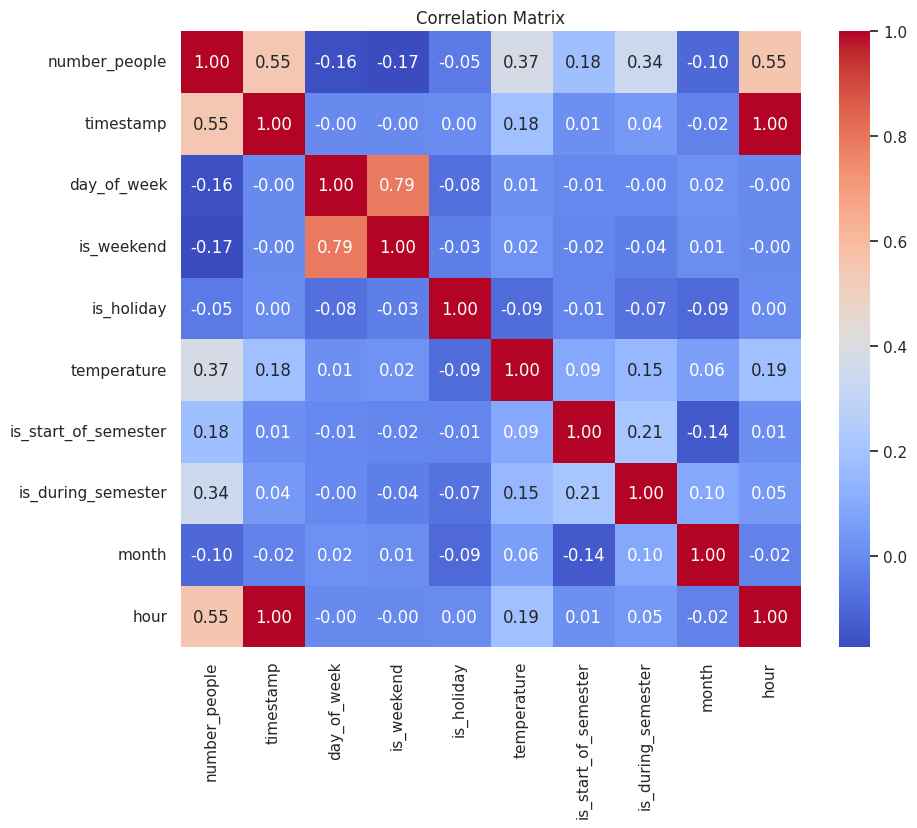

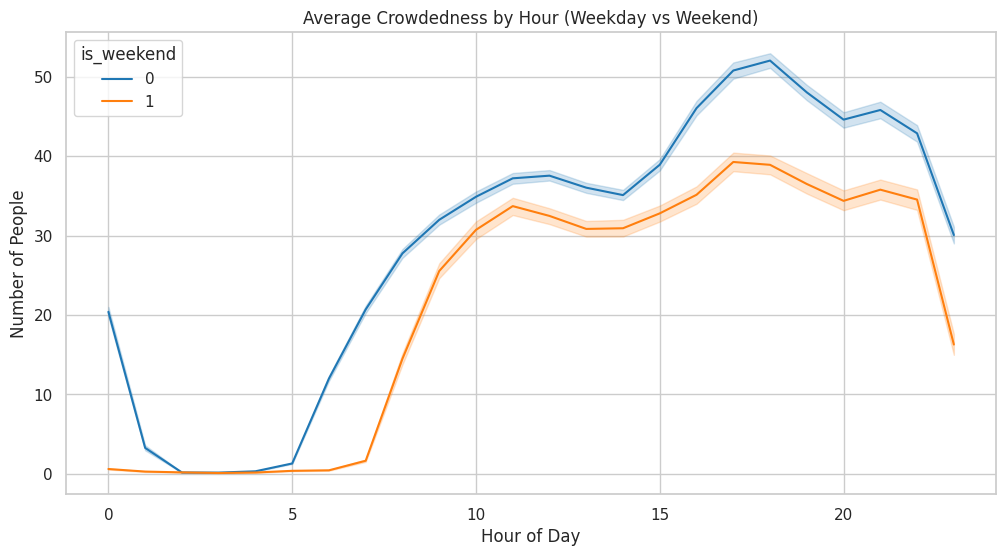

In [10]:
# 1. Correlation Matrix
# We drop 'date' because it is a string and cannot be correlated directly
plt.figure(figsize=(10, 8))
correlation_matrix = df.drop(columns=['date']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 2. Crowd vs Hour of Day
# Visualize the average number of people by hour
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='number_people', data=df, hue='is_weekend', palette='tab10')
plt.title("Average Crowdedness by Hour (Weekday vs Weekend)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of People")
plt.show()

Analysis:

The data reveals that the time of day is the strongest predictor of crowd levels, with attendance consistently peaking in the late afternoon and remaining higher on weekdays compared to weekends. Temperature and academic schedules also significantly influence numbers, showing positive correlations where warmer weather and active semesters lead to increased gym usage while breaks result in a clear drop.

Feature Engineering
Machine learning models often perform better if we transform the data.

Date Parsing: We convert the date column to datetime objects.

Cyclical Features: Time is cyclical (Hour 23 is close to Hour 0). Standard numbers don't capture this (23 and 0 are far apart numerically). We will use Sine and Cosine transformations for hour and month to help the model understand this cycle.

In [11]:
# Convert date to datetime object
df['date'] = pd.to_datetime(df['date'])

# --- Feature Engineering: Cyclical Encoding ---
# We transform 'month' and 'hour' into sin/cos components.

# Month (1-12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Hour (0-23)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Day of week (0-6)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# We can drop the original 'date' column now as we have extracted everything we need
# We keep the original 'hour', 'month', etc., as tree-based models (Random Forest) can handle them,
# but the sin/cos features help capture continuity.
X = df.drop(columns=['number_people', 'date'])
y = df['number_people']

print("Feature Engineering Complete.")
print(f"Total features: {X.shape[1]}")
display(X.head())

Feature Engineering Complete.
Total features: 15


/tmp/ipython-input-460665812.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'])


,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,month_sin,month_cos,hour_sin,hour_cos,day_sin,day_cos
0,61211,4,0,0,71.76,0,0,8,17,-0.866025,-0.5,-0.965926,-0.258819,-0.433884,-0.900969
1,62414,4,0,0,71.76,0,0,8,17,-0.866025,-0.5,-0.965926,-0.258819,-0.433884,-0.900969
2,63015,4,0,0,71.76,0,0,8,17,-0.866025,-0.5,-0.965926,-0.258819,-0.433884,-0.900969
3,63616,4,0,0,71.76,0,0,8,17,-0.866025,-0.5,-0.965926,-0.258819,-0.433884,-0.900969
4,64217,4,0,0,71.76,0,0,8,17,-0.866025,-0.5,-0.965926,-0.258819,-0.433884,-0.900969


Model Training (Random Forest)
We split the data into training (80%) and testing (20%) sets. We then train a Random Forest Regressor.

Why Random Forest? It is an ensemble method that combines many decision trees. It is excellent for "tabular" data like this and prevents overfitting better than a single Decision Tree.

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
# n_estimators=100 means we use 100 trees
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
print("Training the model... (this may take a few seconds)")
model.fit(X_train, y_train)
print("Training complete!")

Training the model... (this may take a few seconds)
Training complete!


Evaluation
We evaluate the model using RMSE (Root Mean Squared Error) and R² Score.

RMSE: Tells us, on average, how wrong our prediction is (in number of people).

R²: Tells us how well the model explains the variance in the data (1.0 is perfect).

Model Performance:
RMSE: 6.44 (The model is off by about 6.44 people on average)
R2 Score: 0.9197 (The model explains 91.97% of the variance)


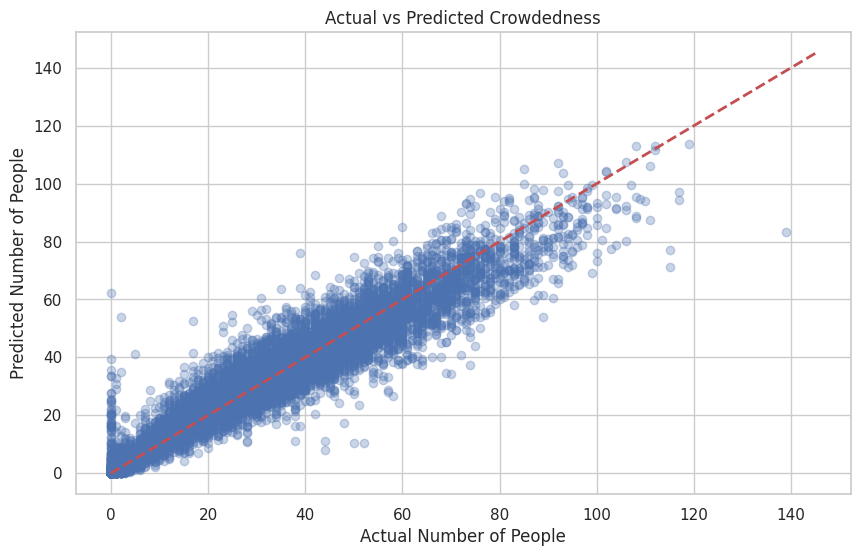

In [13]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.2f} (The model is off by about {rmse:.2f} people on average)")
print(f"R2 Score: {r2:.4f} (The model explains {r2*100:.2f}% of the variance)")

# Visualizing Predictions vs Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Identity line
plt.xlabel("Actual Number of People")
plt.ylabel("Predicted Number of People")
plt.title("Actual vs Predicted Crowdedness")
plt.show()

Feature Importance
One of the best things about Random Forest is that it tells us which features were most important in making a decision.

/tmp/ipython-input-2323167036.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


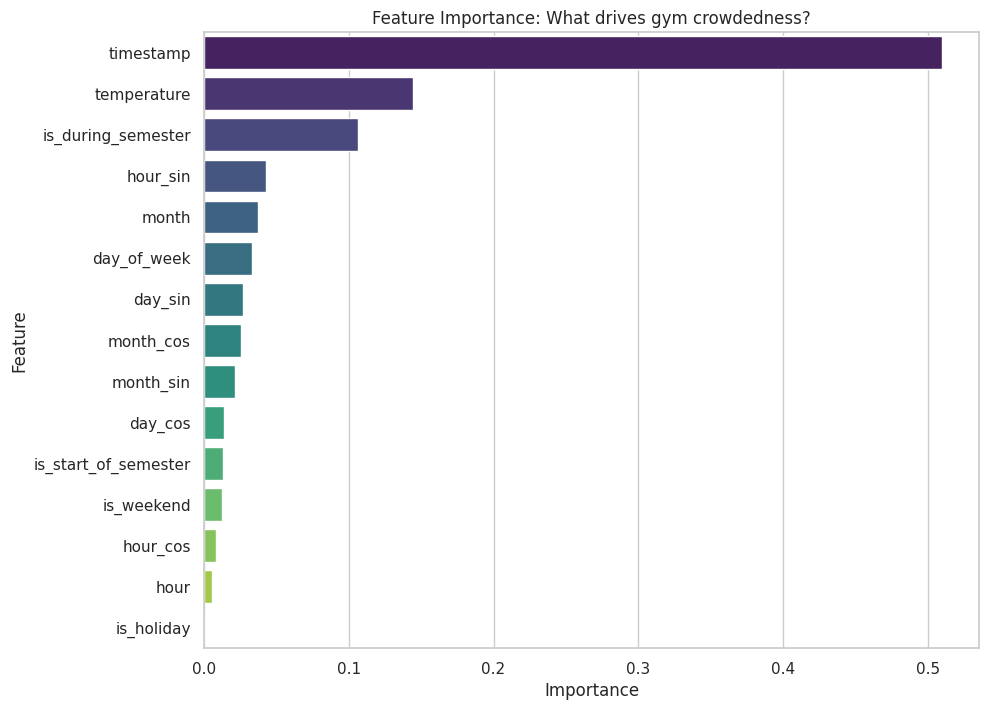

In [14]:
# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance: What drives gym crowdedness?")
plt.show()

In [15]:
# Save the best model to a file
output_file = 'model.pkl'
joblib.dump(model, output_file)

print(f"Model saved successfully as: {output_file}")
print("You can find this file in the 'Files' tab on the left sidebar to download it.")

Model saved successfully as: model.pkl
You can find this file in the 'Files' tab on the left sidebar to download it.
